<a href="https://colab.research.google.com/github/alan-w25/Cancer-Capstone/blob/main/delfi/delfi_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

We will begin to test many models to predict the days alive variable. Procedure we will follow:
1. Choose a model
1. Choose Objective function
1. Choose learning algorithm
1. Add in regularization, adjust hyperparameters, etc

First we will just test the models with all the features, and do some feature selection if need be for statistical methods. It seems that for clinical relevance, we should indeed keep all the samples and should not drop any features of interest

This document will comprise of all the testing of learning models for the delfi_score data. We are aiming to predict the days_alive variable with the survival_status as our event occured indicator. There are several ML methods in literature that have good results and we will use those and other methods to obtain the best results with our data. <br>

Before applying any models, there are two considerations that we can make to transform our data. First, we can uncensor the data, if the number of censored samples is not too great. This method could cause bias in terms of traditional methods <br>

The models that we will be testing have several categories:
1. Linear Models
1. Tree Ensemble Methods
1. Neural Networks
1. Deep Methods



The following procedure will be what we will follow to determine the 'time to death', or the 'days_alive' variable. We will use the models to model the ISDs (individual survival distribution) of the samples and then from there we will use the median time as the survival time. K-fold cross validation will be used to validate the models

Want to use the kaplan-meier curve and the evaluation of those metrics to act as our baseline

In [16]:
!pip3 install scikit-survival

  Using cached scikit_survival-0.22.2-cp310-cp310-macosx_11_0_arm64.whl.metadata (49 kB)
  Using cached ecos-2.0.13.tar.gz (142 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached numexpr-2.9.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (7.9 kB)
  Using cached osqp-0.6.5.tar.gz (228 kB)
  Installing build dependencies ... error
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [121 lines of output]
        Using cached oldest_supported_numpy-2023.12.21-py3-none-any.whl.metadata (9.8 kB)
        Using cached setuptools-69.2.0-py3-none-any.whl.metadata (6.3 kB)
        Using cached wheel-0.43.0-py3-none-any.whl.metadata (2.2 kB)
        Using cached setuptools_scm-8.0.4-py3-none-any.whl.metadata (6.4 kB)
        Using cached qdldl-0.1.7.post0.tar.gz (70 kB)
        Installing build dependencies: star

# Setting up the data

In [1]:
import pandas as pd
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
import sksurv

ModuleNotFoundError: No module named 'sksurv'

In [5]:
data = pd.read_csv('data_Lucas_encoded.csv', index_col=[0])
data.head()

,survival_status,days_alive,delfi_score,stage_I,stage_II,stage_III,stage_IV,treatment_Chemotherapy/Radiation with curative intent,treatment_No treatment,treatment_Palliative Chemotherapy/Radiation,treatment_Surgery,treatment_Surgery+adjuvant treatment
0,1,1059,0.099037,1,0,0,0,0,0,0,1,0
1,1,1640,0.533453,1,0,0,0,0,0,0,1,0
2,1,101,0.822662,0,0,0,1,0,0,1,0,0
3,1,1228,0.238950,0,0,0,1,0,0,1,0,0
4,1,754,0.199820,0,0,1,0,1,0,0,0,0


In [6]:
data['survival_status'] = data['survival_status'].astype('bool')
data.head()

,survival_status,days_alive,delfi_score,stage_I,stage_II,stage_III,stage_IV,treatment_Chemotherapy/Radiation with curative intent,treatment_No treatment,treatment_Palliative Chemotherapy/Radiation,treatment_Surgery,treatment_Surgery+adjuvant treatment
0,True,1059,0.099037,1,0,0,0,0,0,0,1,0
1,True,1640,0.533453,1,0,0,0,0,0,0,1,0
2,True,101,0.822662,0,0,0,1,0,0,1,0,0
3,True,1228,0.238950,0,0,0,1,0,0,1,0,0
4,True,754,0.199820,0,0,1,0,1,0,0,0,0


In [7]:
Y = data[['survival_status', 'days_alive']]
Y = np.array(list(zip(data['survival_status'], data['days_alive'])),
             dtype = [('survival_status', 'bool'), ('days_alive', 'float')])
X = data.drop(['survival_status', 'days_alive', ], axis = 1)
print("X Matrix: ")
print(X.head())
print()

print("Y Matrix: ")
print(Y[1:5])


X Matrix: 
   delfi_score  stage_I  stage_II  stage_III  stage_IV  \
0     0.099037        1         0          0         0   
1     0.533453        1         0          0         0   
2     0.822662        0         0          0         1   
3     0.238950        0         0          0         1   
4     0.199820        0         0          1         0   

   treatment_Chemotherapy/Radiation with curative intent  \
0                                                  0       
1                                                  0       
2                                                  0       
3                                                  0       
4                                                  1       

   treatment_No treatment  treatment_Palliative Chemotherapy/Radiation  \
0                       0                                            0   
1                       0                                            0   
2                       0                                

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 42)

In [9]:
X_train.head()

,delfi_score,stage_I,stage_II,stage_III,stage_IV,treatment_Chemotherapy/Radiation with curative intent,treatment_No treatment,treatment_Palliative Chemotherapy/Radiation,treatment_Surgery,treatment_Surgery+adjuvant treatment
33,0.189878,0,1,0,0,0,0,0,1,0
11,0.158892,0,0,0,1,0,0,0,1,0
44,0.953926,0,0,0,1,0,1,0,0,0
49,0.965122,0,0,1,0,1,0,0,0,0
31,0.678103,0,0,1,0,1,0,0,0,0


In [10]:
X_test.head()

,delfi_score,stage_I,stage_II,stage_III,stage_IV,treatment_Chemotherapy/Radiation with curative intent,treatment_No treatment,treatment_Palliative Chemotherapy/Radiation,treatment_Surgery,treatment_Surgery+adjuvant treatment
68,0.999358,0,1,0,0,0,0,0,1,0
22,0.204565,0,0,0,1,0,0,1,0,0
72,1.000000,0,0,1,0,0,0,1,0,0
73,0.992746,0,0,1,0,1,0,0,0,0
0,0.099037,1,0,0,0,0,0,0,1,0


In [11]:
y_train[0:5]

array([( True, 2254.), ( True,  245.), ( True,   50.), ( True,  364.),
       ( True,  868.)],
      dtype=[('survival_status', '?'), ('days_alive', '<f8')])

In [12]:
y_test[0:5]

array([(False, 2575.), ( True,  575.), ( True,  550.), (False, 2758.),
       ( True, 1059.)],
      dtype=[('survival_status', '?'), ('days_alive', '<f8')])

In [13]:
from sksurv.metrics import concordance_index_censored
def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y["Status"], y["Survival_in_days"], prediction)
    return result



ModuleNotFoundError: No module named 'sksurv'

### Model Training Functions

In [ ]:
# train model function
from sklearn.model_selection import KFold
from Evaluator import ScikitSurvivalEvaluator
def cv_cox_models(model, k_folds, X, y, rs = 0):
    mae_scores = []
    kf = KFold(n_splits = k_folds, shuffle = True, random_state = rs)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        
        survival_curves = model.predict_survival_function(X_test)
        
        eval = ScikitSurvivalEvaluator(survival_curves, y_test['days_alive'], 
                                   y_test['survival_status'], 
                                   y_train['days_alive'], 
                                   y_train['survival_status'], 
                                   predict_time_method="Median")
        mae = eval.mae(method = "Pseudo_obs", weighted = False, log_scale = False)
        mae_scores.append(mae)
        
    return mae_scores
        
    


In [ ]:
def train_full_cox(model, X_tr, y_tr, X_t, y_t, rs = 0): 
    model.fit(X_tr, y_tr)
    surv_c = model.predict_survival_function(X_t)
    eval = ScikitSurvivalEvaluator(surv_c, y_t['days_alive'], 
                                   y_t['survival_status'], 
                                   y_tr['days_alive'], 
                                   y_tr['survival_status'], 
                                   predict_time_method="Median")
    mae = eval.mae(method = "Pseudo_obs", weighted = False, log_scale = False)
    return mae

In [ ]:
def train_model_sksurv(model, X_tr, y_tr, X_t, y_t, criterion, setting = "cox", rs = 0): 
    #want to write a function to train all the possible models that we will have to train
    '''
    Will have to train the following: 
    1. Cox PH Model (sksurv)
    2. Survival SVM (sksurv)
    3. Random Survival Forest (sksurv)
    '''
    
    model.fit(X_tr, y_tr) 
    surv_c = model.predict_survival_function(X_t)
    eval = ScikitSurvivalEvaluator(surv_c, y_t['days_alive'], 
                                   y_t['survival_status'], 
                                   y_tr['days_alive'], 
                                   y_tr['survival_status'], 
                                   predict_time_method="Median")
    mae = eval.mae(method = "Pseudo_obs", weighted = False, log_scale = False)
    return mae

In [ ]:
def cv_model_sksurv(model, X, y, criterion, rs = 0): 
    mae_scores = []
    kf = KFold(n_splits = k_folds, shuffle = True, random_state = rs)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        
        survival_curves = model.predict_survival_function(X_test)
        
        eval = ScikitSurvivalEvaluator(survival_curves, y_test['days_alive'], 
                                   y_test['survival_status'], 
                                   y_train['days_alive'], 
                                   y_train['survival_status'], 
                                   predict_time_method="Median")
        mae = eval.mae(method = "Pseudo_obs", weighted = False, log_scale = False)
        mae_scores.append(mae)
        
    return mae_scores

Before we train any models, a major question in survival analysis is what metric can we use to evaluate our models. The most popular models include:
1. C-Index (Harrell's Concordance Index ) -> Ratio of correctly ordered concordant pairs to comparable pairs. C-Index close to 1 represents perfect prediction
1. MAE (Mean Absolute Error) -> literature has introduced many adaptations of the MAE estimator to handle survival data. This means estimating the true survival time of the censored samples or other methods. This reduces the survival problem down to a typical regression/classification problem.

# Models


## Baseline Kaplan-Meier

In [ ]:
from lifelines import KaplanMeierFitter
from sklearn.model_selection import KFold
import scipy.stats as stats
from Evaluator import LifelinesEvaluator


mae_baseline_scores = []

kf = KFold(n_splits = 5, shuffle = True, random_state = None)

for train_index, test_index in kf.split(y_train):
    y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
    kmf = KaplanMeierFitter()
    survival_curve = kmf.fit(y_train['days_alive'], event_observed=y_train['survival_status']).survival_function_
    
    survival_curve_df = pd.concat([survival_curve] * y_test_cv.shape[0], axis=1)


    eval = LifelinesEvaluator(survival_curve_df, y_test_cv['days_alive'], y_test_cv['survival_status'], y_train_cv['days_alive'], y_train_cv['survival_status'], predict_time_method="Median")
    
    mae = eval.mae(method = "Pseudo_obs", weighted = False, log_scale = False)
    
    mae_baseline_scores.append(mae)
    
average_mae_baseline = np.mean(mae_baseline_scores)

# Calculate the 95% confidence interval
ci_baseline_mae = stats.t.interval(0.95, len(mae_baseline_scores) - 1, loc=average_mae_baseline, scale=stats.sem(mae_baseline_scores))

print(f"Average MAE: {average_mae_baseline}")
print(f"95% CI for the MAE: {ci_baseline_mae}")


Average MAE: 653.1088155262078
95% CI for the MAE: (412.4537589296385, 893.763872122777)


Now test on the test set of the data:

In [ ]:
kmf = KaplanMeierFitter()
survival_curve_baseline = kmf.fit(y_train['days_alive'], event_observed=y_train['survival_status']).survival_function_
survival_curve_base = pd.concat([survival_curve] * y_test.shape[0], axis=1)
eval = LifelinesEvaluator(survival_curve_base, y_test['days_alive'], y_test['survival_status'], y_train['days_alive'], y_train['survival_status'])
mae = eval.mae(method = "Pseudo_obs", weighted = False, log_scale = False)
print(f"MAE for Test Set: {mae}")


MAE for Test Set: 1216.8482142856744


## Linear Models

There is one main linear models that we can use for survival analysis that applies to our distribution of the time to event variable: 
- Cox PH Model 

Cox PH is semi-parametric and outputs the hazard function <br>


### Baseline Cox PH- No Regularization

Let's start with the most basic Cox PH Model

In [ ]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.model_selection import KFold
import scipy.stats as stats
from Evaluator import ScikitSurvivalEvaluator
import math


kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
mae_losses_baseline_cph = []
c_baseline_cph = []

for train_index, test_index in kf.split(X_train):
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
    
    cph = CoxPHSurvivalAnalysis()
    cph.fit(X_train_cv, y_train_cv)
    
    pred_surv = cph.predict_survival_function(X_test_cv)
    
    eval = ScikitSurvivalEvaluator(pred_surv, y_test_cv['days_alive'], 
                                   y_test_cv['survival_status'], 
                                   y_train_cv['days_alive'], 
                                   y_train_cv['survival_status'], 
                                   predict_time_method="Median")
    mae_score = eval.mae(method='Pseudo_obs', weighted=False, log_scale = False)
    c_ind, _, _ = eval.concordance()
    
    if not math.isnan(c_ind):
        c_baseline_cph.append(c_ind) 
    
    mae_losses_baseline_cph.append(mae_score)
    
avg_mae_cph_basic = np.mean(mae_losses_baseline_cph)
avg_c_cph_basic = np.mean(c_baseline_cph)
ci_cph_basic = stats.t.interval(0.95, len(mae_losses_baseline_cph) - 1, loc=avg_mae_cph_basic, scale=stats.sem(mae_losses_baseline_cph))
ci_c_cph_basic = stats.t.interval(0.95, len(c_baseline_cph) - 1, loc=avg_mae_cph_basic, scale=stats.sem(c_baseline_cph))



print(f"Average MAE: {avg_mae_cph_basic}")    
print(f"Confidence Interval: {ci_cph_basic}")
print() 
print(f"Average C-Index: {avg_c_cph_basic}")

Average MAE: 568.5971469509853
Confidence Interval: (374.2865865408963, 762.9077073610745)

Average C-Index: 0.8148359601103504


/common/home/alw228/.local/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=2.14169e-18): result may not be accurate.
  delta = solve(
/common/home/alw228/.local/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=8.37875e-18): result may not be accurate.
  delta = solve(
/common/home/alw228/.local/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=7.67985e-17): result may not be accurate.
  delta = solve(
/common/home/alw228/.local/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=9.63106e-18): result may not be accurate.
  delta = solve(
/common/home/alw228/.local/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=3.04079e-17): result may not be accurate.
  delta = solve(
/common/home/alw228/.local/lib

In [ ]:
cph = CoxPHSurvivalAnalysis(n_iter = 10000)
cph.fit(X_train, y_train)
    
pred_surv = cph.predict_survival_function(X_test)
eval = ScikitSurvivalEvaluator(pred_surv, y_test['days_alive'], 
                                y_test['survival_status'], 
                                y_train['days_alive'], 
                                y_train['survival_status'], 
                                predict_time_method="Median")
mae_score = eval.mae(method='Pseudo_obs', weighted=False, log_scale = False)
print(f"MAE for Test Set: {mae_score}")

MAE for Test Set: 1169.2380445542888


/common/home/alw228/.local/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=2.71099e-17): result may not be accurate.
  delta = solve(
/common/home/alw228/.local/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=1.81677e-17): result may not be accurate.
  delta = solve(
/common/home/alw228/.local/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=2.22822e-17): result may not be accurate.
  delta = solve(
/common/home/alw228/.local/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=1.13809e-17): result may not be accurate.
  delta = solve(
/common/home/alw228/.local/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:449: LinAlgWarning: Ill-conditioned matrix (rcond=3.66053e-17): result may not be accurate.
  delta = solve(
/common/home/alw228/.local/lib

Our baseline cox ph model seems to fit the data worse than the baseline Kaplan meier model. However, it seems to generalize much better than the baseline model. Furthermore, while in this random state = 42, the model ran, there are other random_states in which there is too much multicollinearity between covariates, indicating we definitely need regularization

### Ridge Cox PH - Finding the Best Regularization Penalty

Let's test better versions of the Cox model: perhaps a regularized model to regularize the features that we determined were not valuable in the exploration process. Use cv to search for the best alpha value for regularization

In [ ]:
def find_best_alpha_cph(alpha_vals, k_folds, X, y, rs): 
    
    kf = KFold(n_splits = k_folds, shuffle = True, random_state = rs)
    avg_maes = []
    best_alpha = None
    min_avg_mae = float('inf')
    
    for a in alpha_vals:
        mae_scores = []
        model = None
        model = CoxPHSurvivalAnalysis(alpha = a, n_iter = 10000)
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            model.fit(X_train, y_train)
            
            survival_curves = model.predict_survival_function(X_test)
            
            eval = ScikitSurvivalEvaluator(survival_curves, y_test['days_alive'], 
                                    y_test['survival_status'], 
                                    y_train['days_alive'], 
                                    y_train['survival_status'], 
                                    predict_time_method="Median")
            mae = eval.mae(method = "Pseudo_obs", weighted = False, log_scale = False)
            mae_scores.append(mae)
            
        avg_mae = np.mean(mae_scores)
        avg_maes.append(avg_mae)

        if avg_mae < min_avg_mae:
            min_avg_mae = avg_mae
            best_alpha = a

    return best_alpha, min_avg_mae, avg_maes


In [ ]:
alpha_vals = 10**np.linspace(-5, 5, 50)
best_initial_alpha, min_avg_mae_init, avg_maes_init = find_best_alpha_cph(alpha_vals, 5, X_train, y_train, 0)
print(f"Best Alpha Value: {best_initial_alpha}")
print(f"Minimum average mae of best alpha: {min_avg_mae_init}")

Best Alpha Value: 1.2648552168552958
Minimum average mae of best alpha: 370.88333296661676


In [ ]:
cph_ridge_init = CoxPHSurvivalAnalysis(alpha = best_initial_alpha, n_iter = 10000)
mae_cph_ridge= cv_cox_models(cph_ridge_init, 5, X_train, y_train)


In [ ]:
mae_init_cph_ridge = train_full_cox(cph_ridge_init, X_train, y_train, X_test, y_test)
print(f"Final Test MAE for Ridge Cox: {mae_init_cph_ridge}")

Final Test MAE for Ridge Cox: 1040.200173723492


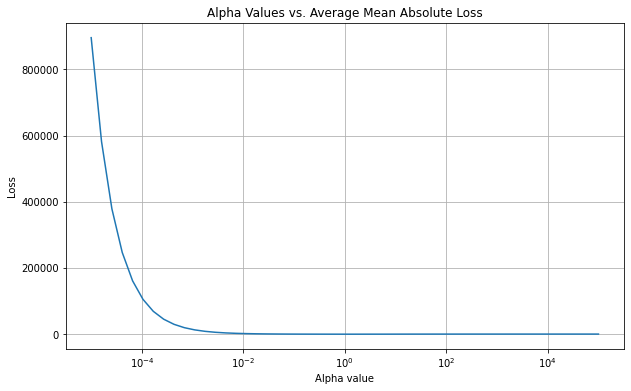

In [ ]:
plt.figure(figsize = (10,6))
plt.title("Alpha Values vs. Average Mean Absolute Loss")
plt.plot(alpha_vals, avg_maes_init)
plt.xlabel("Alpha value")
plt.xscale("log")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [ ]:
print(alpha_vals)

[1.00000000e-05 1.59985872e-05 2.55954792e-05 4.09491506e-05
 6.55128557e-05 1.04811313e-04 1.67683294e-04 2.68269580e-04
 4.29193426e-04 6.86648845e-04 1.09854114e-03 1.75751062e-03
 2.81176870e-03 4.49843267e-03 7.19685673e-03 1.15139540e-02
 1.84206997e-02 2.94705170e-02 4.71486636e-02 7.54312006e-02
 1.20679264e-01 1.93069773e-01 3.08884360e-01 4.94171336e-01
 7.90604321e-01 1.26485522e+00 2.02358965e+00 3.23745754e+00
 5.17947468e+00 8.28642773e+00 1.32571137e+01 2.12095089e+01
 3.39322177e+01 5.42867544e+01 8.68511374e+01 1.38949549e+02
 2.22299648e+02 3.55648031e+02 5.68986603e+02 9.10298178e+02
 1.45634848e+03 2.32995181e+03 3.72759372e+03 5.96362332e+03
 9.54095476e+03 1.52641797e+04 2.44205309e+04 3.90693994e+04
 6.25055193e+04 1.00000000e+05]


The range for alphas is still very large so we want to narrow that down and pick a potential even better penalty

In [ ]:
num_values = 50  # Number of values to test around the best alpha

# Create an array of values centered around the best alpha
alpha_range = np.linspace(0.01, best_initial_alpha + 2, num_values)

In [ ]:
best_alpha_, min_avg_mae_final, avg_maes_final = find_best_alpha_cph(alpha_range, 5, X_train, y_train, 0)
print(f"Best alpha after narrowing range: {best_alpha_}")


Best alpha after narrowing range: 1.338512333410325


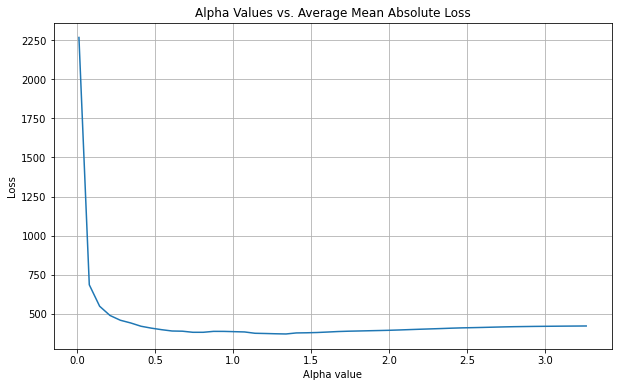

In [ ]:
plt.figure(figsize = (10,6))
plt.title("Alpha Values vs. Average Mean Absolute Loss")
plt.plot(alpha_range, avg_maes_final)
plt.xlabel("Alpha value")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [ ]:
cph_ridge_final = CoxPHSurvivalAnalysis(alpha = best_alpha_, n_iter = 10000)
mae_cph_ridge= cv_cox_models(cph_ridge_final, 5, X_train, y_train)

print(f"Average MAE For CPH with Ridge Penalty: {np.mean(mae_cph_ridge)}")

Average MAE For CPH with Ridge Penalty: 369.4460323035417


In [ ]:
mae_final_cph_ridge = train_full_cox(cph_ridge_final, X_train, y_train, X_test, y_test)
print(f"Final Test MAE for Ridge Cox: {mae_final_cph_ridge}")

Final Test MAE for Ridge Cox: 1033.9524618896446


Performance seems to be the same as the previous model. Maybe the regularization is not strong enough? Or the regularization does not generalize very well. We can instead apply 100% LASSO Regularization to see if that does any better than our previous model.

### LASSO Cox

In sksurv, the LASSO penalty can be applied through the Cox Elastic Net model, which leverages elastic net penalization. Our goal is to see if pure LASSO regularization can perform better than the ridge regularization that we tested above. Eventually, we want to choose a good ratio between the L1:L2 regularization terms to hopefully get a more accurate model.

In [ ]:
#use cv to find average loss values
from sksurv.linear_model import CoxnetSurvivalAnalysis
cox_lasso_init = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio = 0.01, fit_baseline_model= True)
avg_lasso_mae = cv_cox_models(cox_lasso_init, 5, X_train, y_train)
print(f"Average LASSO MAE: {np.mean(avg_lasso_mae)}")

Average LASSO MAE: 813.0682131488227


In [ ]:
mae_final_init_lasso = train_full_cox(cox_lasso_init, X_train, y_train, X_test, y_test)
print(f"Initial LASSO Model MAE: {mae_final_init_lasso}")


Initial LASSO Model MAE: 1075.445329343369


In [ ]:
alpha_scores = cox_lasso_init.alphas_

Want to use GridSearchCV to find a better L1 L2 ratio since we are seeing that the Lasso model performs worse than the Ridge model. We also need to write a custom scorer to test this grid search method.

In [ ]:
from sklearn.metrics import make_scorer
def custom_scorer_cox(model, X, y):
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    survival_function = model.predict_survival_function(X)
    print("Inputs: ")
    print(X[:3])
    print("ys: ")
    print(y[:3])
    eval = ScikitSurvivalEvaluator(survival_function, test_event_times=y['days_alive'], test_event_indicators=y['survival_status'], predict_time_method = "Median")
    mae = eval.mae(method = "Pseudo_obs", weighted = False, log_scale = False)
    return mae
custom_scorer = make_scorer(custom_scorer_cox, greater_is_better=False)    

In [ ]:
print("Possible alpha values: ")
print(alpha_scores)

Possible alpha values: 
[0.2923434  0.27905594 0.26637242 0.25426538 0.24270863 0.23167715
 0.22114706 0.21109559 0.20150097 0.19234244 0.18360018 0.17525526
 0.16728964 0.15968607 0.15242809 0.1455     0.1388868  0.13257418
 0.12654848 0.12079666 0.11530626 0.11006541 0.10506277 0.10028751
 0.09572928 0.09137824 0.08722496 0.08326045 0.07947613 0.07586382
 0.07241569 0.06912429 0.06598248 0.06298348 0.06012078 0.0573882
 0.05477982 0.05228999 0.04991333 0.04764469 0.04547917 0.04341207
 0.04143892 0.03955546 0.0377576  0.03604146 0.03440332 0.03283964
 0.03134702 0.02992225 0.02856224 0.02726404 0.02602485 0.02484198
 0.02371287 0.02263509 0.02160629 0.02062425 0.01968685 0.01879205
 0.01793792 0.01712261 0.01634436 0.01560149 0.01489238 0.01421549
 0.01356938 0.01295263 0.01236391 0.01180195 0.01126554 0.0107535
 0.01026474 0.00979819 0.00935285 0.00892775 0.00852197 0.00813463
 0.0077649  0.00741197 0.00707509 0.00675351 0.00644655 0.00615355
 0.00587386 0.00560688 0.00535204 0.0051

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(CoxnetSurvivalAnalysis(l1_ratio=1.0, fit_baseline_model= True))
coxlasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, fit_baseline_model= True)
cv = KFold(n_splits=5, shuffle=True, random_state=0)
param_grid = [[v] for v in alpha_scores]
grid_search = GridSearchCV(
    estimator = coxlasso,
    param_grid = {"alphas":param_grid}, 
    cv = 5,
    scoring = custom_scorer)


grid_search.fit(X_train,y_train)


KeyboardInterrupt: 

In [89]:
full_mae_lasso = train_full_cox(best_cox_lasso, X_train, y_train, X_test, y_test)
print(f"Final LASSO MAE on Full Train and Test Set: {full_mae_lasso}")


Final LASSO MAE on Full Train and Test Set: 1216.4844884388524


/tmp/ipykernel_2933064/292684294.py:2: UserWarning: all coefficients are zero, consider decreasing alpha.
  model.fit(X_tr, y_tr)


This value with just Lasso regression seems to be much lower than that of just ridge regression. However, the validation MAE is higher. This model generalizes better. Next, we will use cv to test the ElasticNet and find the optimal balance between L1 and L2 regularization.

### ElasticNet Cox Ph - Finding the best L1:L2 Ratio

In [63]:
#k-fold cv to find the best l1:l2 ratio
def find_best_l1r(ratio_vals, k_folds, X, y, rs = 0): 
    avg_maes = []
    best_r = None
    min_avg_mae = float('inf')
    kf = KFold(n_splits = k_folds, shuffle = True, random_state = rs)

    
    for r in ratio_vals: 
        mae_scores = [] 
        model = CoxnetSurvivalAnalysis(l1_ratio= r, alpha_min_ratio = 0.01, fit_baseline_model= True)
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            model.fit(X_train, y_train)
            
            survival_curves = model.predict_survival_function(X_test)
            
            eval = ScikitSurvivalEvaluator(survival_curves, y_test['days_alive'], 
                                    y_test['survival_status'], 
                                    y_train['days_alive'], 
                                    y_train['survival_status'], 
                                    predict_time_method="Median")
            mae = eval.mae(method = "Pseudo_obs", weighted = False, log_scale = False)
            mae_scores.append(mae)
            
        avg_mae = np.mean(mae_scores)
        avg_maes.append(avg_mae)

        if avg_mae < min_avg_mae:
            min_avg_mae = avg_mae
            best_r = r

    return best_r, min_avg_mae, avg_maes

In [64]:
l1_ratios = np.linspace(0.01,1,50)
best_r, min_avg_mae_r, avg_r_mae = find_best_l1r(l1_ratios, 5, X_train, y_train)

print(f"Best L1 Ratio: {best_r}")
print(f"Validation MAE of Best r: {min_avg_mae_r}")

Best L1 Ratio: 0.1716326530612245
Validation MAE of Best r: 382.2513423441968


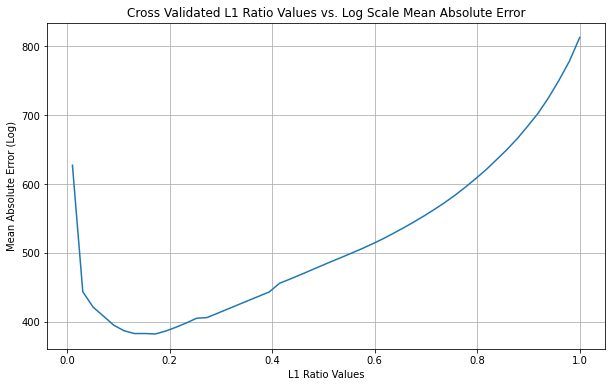

In [65]:
plt.figure(figsize=(10,6))
plt.plot(l1_ratios, avg_r_mae)
plt.xlabel("L1 Ratio Values")
plt.ylabel("Mean Absolute Error (Log)")
plt.title("Cross Validated L1 Ratio Values vs. Log Scale Mean Absolute Error")
plt.grid()
plt.show()

In [66]:
best_elastinet_cox = CoxnetSurvivalAnalysis(l1_ratio=best_r, alpha_min_ratio = 0.01, fit_baseline_model = True)
final_elasti_mae = train_full_cox(best_elastinet_cox, X_train, y_train, X_test, y_test)
print(f"Final MAE of ElasticNet Regularized Cox PH Model: {final_elasti_mae}")

Final MAE of ElasticNet Regularized Cox PH Model: 1043.9722393162447


Overall, the different cox models yielded ok results, with the test log MAE landing around 1.05 - 1.08, which performed better than the original model with no regularization

## Accelerated Failure Time Model

## SVM

The procedure for SVM will be the same as for the Cox Proportional Hazards Model. We will train a model then utilize GridSearchCV with MAE scoring to evaluate the models found. Let's use the regression setting on sksurv's SVM model (which predicts the event time of the input) and then calculate our own log mae from the predictions. We will take log(predictions) - log(ground truth)

In [31]:
def calculate_mae(y_true, y_pred, log_transform=False):
    if log_transform:
        y_true = np.log(y_true)
        y_pred = np.log(y_pred)

    absolute_errors = np.abs(y_true - y_pred)
    mae = np.mean(absolute_errors)
    return mae

In [ ]:
from sksurv.svm import FastSurvivalSVM
def train_svm(X_tr, X_t, y_tr, y_t, alpha, rs = 0): 
    model = FastSurvivalSVM(max_iter = 10000, tol = 1e-6, random_State = rs, rank_ratio = 0.0, alpha = alpha)

In [ ]:
def find_best_alpha(): 
    

In [38]:
from sksurv.svm import FastSurvivalSVM

svm_model = FastSurvivalSVM(max_iter = 10000, tol = 1e-5, random_state = 0, rank_ratio = 0.0, fit_intercept = True)

svm_model.fit(X_train, y_train)
predictions = svm_model.predict(X_test)
print(predictions[0:5])
print(y_test[0:5])


print(calculate_mae(predictions, y_test['days_alive'], log_transform = False))


[1424.1526646   203.27066452  339.17025622  617.68009813 2198.92892772]
[(False, 2575.) ( True,  575.) ( True,  550.) (False, 2758.)
 ( True, 1059.)]
853.815713528997


## Random Survival Forest

## MTLR